https://qiita.com/m__k/items/98ff5fb4a4cb4e1eba26
↑ここのやつを動かしている
単語ベクトルはkaggleからとってきたgloveの単語ベクトル

In [1]:
# torchtext
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
from torchtext.vocab import Vectors

# pytorch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

# その他もろもろ
import os
import pickle
import numpy as np
import pandas as pd
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 最後にattentionを可視化するときに使います。
import itertools
import random
from IPython.display import display, HTML

import MeCab
import gensim

In [2]:
#nltk_analyzer("I have a pen.")

In [3]:
me = MeCab.Tagger ("-Owakati")
def mecab_tokenizer(text):
    return me.parse(text).split()

# train.tsv, test.tsvをここに置いとく
imdb_dir = "./datas"

# glove.6B.200d.txtをここに置いとく
word_embedding_dir = "./"

TEXT = data.Field(sequential=True, tokenize=mecab_tokenizer, lower=True, include_lengths=True, batch_first=True)
TEXT_nobatch = data.Field(sequential=True, tokenize=mecab_tokenizer, lower=True, include_lengths=True, batch_first=False)

LABEL = data.Field(sequential=False, use_vocab=False, is_target=True)

train, test = data.TabularDataset.splits(
      path=imdb_dir, train='train_class.tsv', test='test_class.tsv', format='tsv',
      fields=[('Text', TEXT), ('Label', LABEL)])

#glove_vectors = Vectors(name=word_embedding_dir + "glove.6B.200d.txt")

#TEXT.build_vocab(train, vectors=glove_vectors, min_freq=1)

In [4]:
train.examples[0].Text

['友人', '代表', 'の', 'スピーチ', '、', '独', '女', 'は', 'どう', 'こなし', 'て', 'いる', '？']

In [5]:
kakko_labels = [0,0]

for i, ex in enumerate(test.examples):
        #print(i.Text)
        if "【" in ex.Text or "】" in ex.Text:
            kakko_labels[int(ex.Label)] += 1

In [6]:
kakko_labels

[47, 506]

In [7]:
embedding = gensim.models.KeyedVectors.load_word2vec_format("model.vec")

In [8]:
#labels[0]

In [9]:
#len(embedding.index2word)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

BATCH_SIZE = 100 # バッチサイズ
EMBEDDING_DIM = 300 # 単語の埋め込み次元数
LSTM_DIM = 128 # LSTMの隠れ層の次元数
#VOCAB_SIZE = len(embedding.index2word) # 全単語数
TAG_SIZE = 2 # 今回はネガポジ判定を行うのでネットワークの最後のサイズは2
DA = 128 # AttentionをNeural Networkで計算する際の重み行列のサイズ
R = 1 # Attentionの数

In [11]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, embedding_dim, lstm_dim):
        super(BiLSTMEncoder, self).__init__() #親の__init__で一回初期化する
        self.lstm_dim = lstm_dim
        
        # bidirectional=Trueでお手軽に双方向のLSTMにできる
        self.bilstm = nn.LSTM(embedding_dim, lstm_dim, batch_first=True, bidirectional=True)

    def forward(self, sentences):
        #print("forward")
        #分かち書きテキストが来るのでembeddingにする
        embeds = []
        for s in sentences:
            #print(s)
            vecs = []
            for w in s:
                if w in embedding:
                    vecs.append(embedding[w])
                else:
                    vecs.append(np.zeros(EMBEDDING_DIM))
            #vecs = torch.tensor(vecs)
            #print(vecs.shape)
            embeds.append(vecs)
            
        embeds = torch.tensor(embeds).float()
        #print("embeddings shape {}".format(embeds.shape))
        
        # 各隠れ層のベクトルがほしいので第１戻り値を受け取る
        out, _ = self.bilstm(embeds)

        # 前方向と後ろ方向の各隠れ層のベクトルを結合したままの状態で返す
        return out

In [12]:
class SelfAttention(nn.Module):
  def __init__(self, lstm_dim, da, r):
    super(SelfAttention, self).__init__()
    self.lstm_dim = lstm_dim
    self.da = da
    self.r = r
    self.main = nn.Sequential(
        # Bidirectionalなので各隠れ層のベクトルの次元は２倍のサイズになってます。
        nn.Linear(lstm_dim * 2, da), 
        nn.Tanh(),
        nn.Linear(da, r)
    )
  def forward(self, out):
    return F.softmax(self.main(out), dim=1)

In [13]:
class SelfAttentionClassifier(nn.Module):
  def __init__(self, lstm_dim, da, r, tagset_size):
    super(SelfAttentionClassifier, self).__init__()
    self.lstm_dim = lstm_dim
    self.r = r
    self.attn = SelfAttention(lstm_dim, da, r)
    self.main = nn.Linear(lstm_dim * 2 * r, tagset_size)

  def forward(self, out):
    attention_weight = self.attn(out)
    
    feats = torch.tensor([], device=device)
    for i in range(self.r):
        m1 = (out * attention_weight[:,:,i].unsqueeze(2)).sum(dim=1)
        feats = torch.cat([feats, m1], dim = 1)
    #m1 = (out * attention_weight[:,:,0].unsqueeze(2)).sum(dim=1)
    #m2 = (out * attention_weight[:,:,1].unsqueeze(2)).sum(dim=1)
    #m3 = (out * attention_weight[:,:,2].unsqueeze(2)).sum(dim=1)
    #feats = torch.cat([m1, m2, m3], dim=1)
    return F.log_softmax(self.main(feats)), attention_weight

In [14]:
def makeWordsBatch(examples, batch_size):
    datas = []
    for i in examples.examples:
        #print(i.Text)
        datas.append([i.Text, i.Label])
    
    #train, test = train_test_split(datas, test_size=0.2, shuffle = True)
    
    datas = sorted(datas, key=lambda x: len(x[0]), reverse=True)
    #print(datas)
    batchs = []
    for i in range(0, len(datas), batch_size):
        batch = datas[i : min(len(datas), i+batch_size)]
        
        maxLengh = len(batch[0][0])
        for j in range(len(batch)):
            #if len(batch[j][0]) < maxLengh:
                #print("pad")
            batch[j][0] += ["[PAD]"]*(maxLengh-len(batch[j][0]))
            #print(batch[j])
        batchs.append(np.array(batch))
    
    return batchs

In [15]:
encoder = BiLSTMEncoder(EMBEDDING_DIM, LSTM_DIM).to(device)
classifier = SelfAttentionClassifier(LSTM_DIM, DA, R, TAG_SIZE).to(device)
loss_function = nn.NLLLoss()

# 複数のモデルを from itertools import chain で囲えばoptimizerをまとめて1つにできる
optimizer = optim.Adam(chain(encoder.parameters(), classifier.parameters()), lr=0.001)

train_batch = makeWordsBatch(train, BATCH_SIZE)
test_batch = makeWordsBatch(test, BATCH_SIZE)

In [16]:
losses = []
stop_count = 0
best_loss = 10000

for epoch in range(100):
    epoch_loss = 0
    #print(train_batch)
    for idx, batch in enumerate(train_batch):
        #print(idx)
        #print(batch)
        
        batch_loss = 0
        encoder.zero_grad()
        classifier.zero_grad()

        text_tensor = batch[:, 0]
        #print("text tensor shape{}".format(text_tensor.shape))
        label_tensor = batch[:, 1].astype(np.long)
        label_tensor = torch.from_numpy(label_tensor)
        #print(label_tensor.size())
        out = encoder(text_tensor)
        #print(out.size())
        score, attn = classifier(out)
        #print(score.size())
        #print(score)
        #print(label_tensor.size())
        #print(label_tensor)
        batch_loss = loss_function(score, label_tensor)
        batch_loss.backward()
        optimizer.step()
        epoch_loss += batch_loss.item()
        
        #break
        
    print("epoch", epoch, "\t" , "loss", epoch_loss)
    
    #終了条件（ガバガバ）
    if best_loss - epoch_loss < 0.01:
        #print("更新できず")
        stop_count += 1
        if stop_count > 5:
            break
    else:
        stop_count = 0
        
    if best_loss > epoch_loss:
        best_loss = epoch_loss
    
    losses.append(epoch_loss)
#epoch 0     loss 97.37978366017342
#epoch 1     loss 50.07680431008339
#epoch 2     loss 27.79373042844236
#epoch 3     loss 9.353876578621566
#epoch 4     loss 1.9509600398596376
#epoch 5     loss 0.22650832029466983
#epoch 6     loss 0.021685686125238135
#epoch 7     loss 0.011305359620109812
#epoch 8     loss 0.007448446772286843
#epoch 9     loss 0.005398457038154447

<ipython-input-13-1f20314e62cf>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.main(feats)), attention_weight


epoch 0 	 loss 43.71581791341305
epoch 1 	 loss 31.060765251517296
epoch 2 	 loss 25.640651881694794
epoch 3 	 loss 26.564660646021366
epoch 4 	 loss 20.542380791157484
epoch 5 	 loss 14.590887319296598
epoch 6 	 loss 12.521175934001803
epoch 7 	 loss 10.498157802969217
epoch 8 	 loss 9.344554176554084
epoch 9 	 loss 8.329964959761128
epoch 10 	 loss 6.985395222029183
epoch 11 	 loss 5.840874685673043
epoch 12 	 loss 4.79038558609318
epoch 13 	 loss 3.8382821249833796
epoch 14 	 loss 3.123822103982093
epoch 15 	 loss 3.1677562475961167
epoch 16 	 loss 3.0932017067971174
epoch 17 	 loss 3.188196316783433
epoch 18 	 loss 2.5356567108538
epoch 19 	 loss 2.199875472644635
epoch 20 	 loss 1.6431942588624224
epoch 21 	 loss 2.660175201614038
epoch 22 	 loss 1.8221130265592365
epoch 23 	 loss 1.1801957328498247
epoch 24 	 loss 0.94119790438981
epoch 25 	 loss 0.8679495206233696
epoch 26 	 loss 0.6514129947954643
epoch 27 	 loss 0.9034361888498097
epoch 28 	 loss 1.4792188552382868
epoch 29 	 

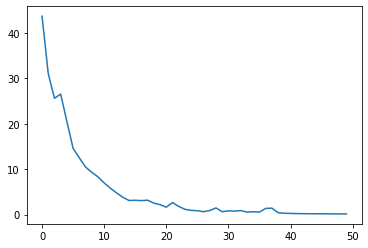

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [18]:
torch.save(encoder.state_dict(), "encoder.trained")
torch.save(classifier.state_dict(), "classifier.trained")

In [19]:
answer = []
prediction = []

zero_predictions = []

with torch.no_grad():
    for batch in test_batch:

        text_tensor = batch[:, 0]
        #print("text tensor shape{}".format(text_tensor.shape))
        label_tensor = batch[:, 1].astype(np.long)
        label_tensor = torch.from_numpy(label_tensor)

        out = encoder(text_tensor)
        #print(out)
        score, _ = classifier(out)
        _, pred = torch.max(score, 1)
        #print(score[:,0].tolist())
        #ラベル0の出力を全部記録する
        zero_predictions = zero_predictions+score[:,0].tolist()
        print(len(zero_predictions))

        prediction += list(pred.cpu().numpy())
        answer += list(label_tensor.cpu().numpy())
print(classification_report(prediction, answer, target_names=['positive', 'negative']))

<ipython-input-13-1f20314e62cf>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.main(feats)), attention_weight


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1723
              precision    recall  f1-score   support

    positive       0.97      0.93      0.95       946
    negative       0.92      0.97      0.94       777

    accuracy                           0.95      1723
   macro avg       0.95      0.95      0.95      1723
weighted avg       0.95      0.95      0.95      1723



In [19]:
#print(zero_predictions)
%matplotlib inline

zero_predictions.sort()

plt.plot(zero_predictions)

NameError: name 'plt' is not defined

In [18]:
def highlight(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

def mk_html(sentence, attns):
    html = ""
    for word, attn in zip(sentence, attns):
        html += ' ' + highlight(
            word,
            attn
        )
        #print(word)
        #print(TEXT.vocab.itos[word])
    return html

id2ans = {1: 'positive', 0:'negative'}

#print(id2ans[1])

test_batch_1 = makeWordsBatch(test, 1)

n = random.randrange(len(test_batch_1))

for batch in itertools.islice(test_batch_1, n-1,n):
    text_tensor = batch[:, 0]
    print(text_tensor)
    #print("text tensor shape{}".format(text_tensor.shape))
    label_tensor = batch[:, 1].astype(np.long)
    label_tensor = torch.from_numpy(label_tensor)
    #print(label_tensor[0])
    
    encoder_outputs = encoder(text_tensor)
    output, attn = classifier(encoder_outputs)
    pred = output.data.max(1, keepdim=True)[1]
    print(pred)
    print(output[0])
    display(HTML('【正解】' + id2ans[int(label_tensor)] + '\t【予測】' + id2ans[int(pred)] + '<br><br>'))
    #print(attn)
    for i in range(attn.size()[2]):
      display(HTML(mk_html(text_tensor[0], attn.data[0,:,i]) + '<br><br>'))

[list(['「', 'めざまし', 'テレビ', '」', '大塚', '範一', 'アナ', 'の', '“', '卒業', '”', 'が', 'ネット', '上', 'で', '話題', '[PAD]'])]
tensor([[0]])
tensor([-1.3947e-05, -1.1177e+01], grad_fn=<SelectBackward>)


<ipython-input-13-1f20314e62cf>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.main(feats)), attention_weight


In [19]:
text = input()
text_tensor = np.array([mecab_tokenizer(text)])
print(text_tensor)

id2ans = {1: 'positive', 0:'negative'}

encoder_outputs = encoder(text_tensor)
output, attn = classifier(encoder_outputs)
pred = output.data.max(1, keepdim=True)[1]

print(output[0])
#print("{:.02f}".format(np.power(np.e , float(output[0][0]))))
print("再生回数：{:.0f}回".format(-300 * np.power(float(output[0][0]),3) ))
print(pred)
print(id2ans[int(pred)])
display(HTML( '\t【予測】' + id2ans[int(pred)] + '<br><br>'))
#print(attn)
for i in range(attn.size()[2]):
  display(HTML(mk_html(text_tensor[0], attn.data[0,:,i]) + '<br><br>'))

【神回】バズレンダでマナが大変なことに?!【驚愕】
[['【' '神' '回' '】' 'バズレンダ' 'で' 'マナ' 'が' '大変' 'な' 'こと' 'に' '?!【' '驚愕' '】']]
tensor([-1.5796e+01, -1.1921e-07], grad_fn=<SelectBackward>)
再生回数：1182330回
tensor([[1]])
positive


<ipython-input-13-1f20314e62cf>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.main(feats)), attention_weight


新型フラフープで超効率独自シェイプアップ術！